In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from joblib import dump, load
from tensorflow.keras.models import load_model

In [24]:
# Load the dataset
mat = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines.mat')
mat_gt = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines_gt.mat')

data = mat['indian_pines']
labels = mat_gt['indian_pines_gt']

In [40]:
# Reshape the data to (num_samples, num_features)
n, m, num_samples = data.shape
data_reshaped = np.reshape(data, (n*m, num_samples))
labels_reshaped = np.reshape(labels, (n*m,))

# Apply LDA to reduce the dimensionality of the data
num_components = 16
pipeline = Pipeline([('scaling', StandardScaler()), ('lda', LDA(n_components=num_components))])
data_lda = pipeline.fit_transform(data_reshaped, labels.ravel())

dump(pipeline, 'lda_pipeline.joblib')

from keras.models import Sequential
from keras.layers import Dense, Conv1D

# Define the neural network architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=data_lda.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(17, activation='softmax'))

model.summary()

# Compile the model with categorical cross-entropy loss and Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert labels to one-hot encoding
num_labels = len(np.unique(labels_reshaped))
labels_onehot = np.eye(num_labels)[labels_reshaped.reshape(-1)]

# print(labels_onehot)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_lda, labels_onehot, test_size=0.3, random_state=42)

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)
# Train the neural network on the training set
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the neural network on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", accuracy)

model.save('lda_model.h5')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                1088      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 17)                561       
                                                                 
Total params: 3,729
Trainable params: 3,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
368/368 [==============================] - 1s 2ms/step - loss: 1.1965 - accuracy: 0.6512 - val_loss: 0.8041 - val_accuracy: 0.7208
Epoch 2/50
368/368 [==============================] - 1s 2ms/step - loss: 0.7094 - accuracy: 0.7408 - val_loss: 0.6874 - val_accuracy: 0.7435
Epoch 3/50
368/368 [============

658/658 [==============================] - 2s 3ms/step
Clustered labels accuracy: 0.8172651605231867
MSE: 17.935933412604044


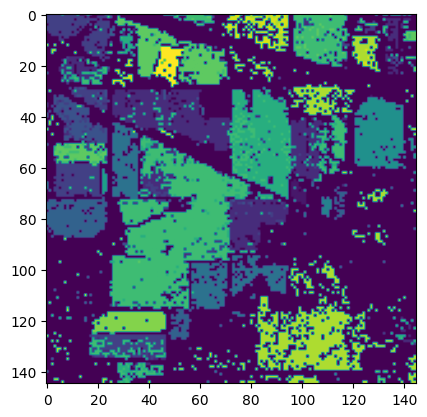

In [27]:
# Reshape the cluster labels and display the segmented image
cluster_labels_onehot = model.predict(data_lda)
# smoothed_preds = np.apply_along_axis(lambda x: np.convolve(x, [1/3, 1/3, 1/3], mode='same'), axis=1, arr=cluster_labels_onehot)
cluster_labels = np.argmax(cluster_labels_onehot, axis=1)

cluster_labels_reshaped = np.reshape(cluster_labels, (n, m))
accuracy = np.mean(cluster_labels_reshaped == labels)
print("Clustered labels accuracy:", accuracy)

cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
plt.imshow(cluster_labels_reshaped)
plt.show()

658/658 [==============================] - 2s 3ms/step


100%|██████████| 299/299 [00:00<00:00, 562.33it/s]


Best sigma=1.1 with accuracy=0.8868
MSE: 15.902734839476814


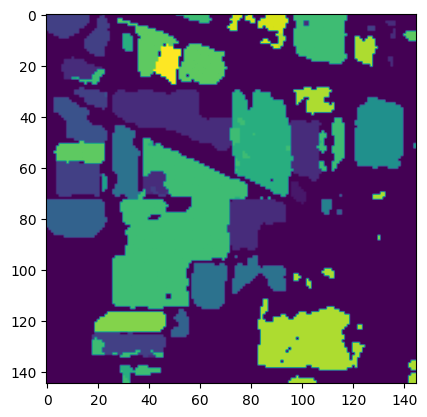

In [28]:
import cv2
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

sigmas = np.arange(0.01, 3.00, 0.01)  # different values of sigma to try
best_accuracy = 0
best_sigma = 0

# Reshape the cluster labels and display the segmented image
cluster_labels_onehot = model.predict(data_lda)
preds = np.reshape(cluster_labels_onehot, (n, m, 17))

for sigma in tqdm(sigmas):
    smoothed_preds = cv2.GaussianBlur(preds, (0, 0), sigma)

    cluster_labels_reshaped = np.argmax(smoothed_preds, axis=2)
    accuracy = np.mean(cluster_labels_reshaped == labels)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sigma = sigma
        best_image = cluster_labels_reshaped

print(f"Best sigma={best_sigma:.1f} with accuracy={best_accuracy:.4f}")

cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
plt.imshow(best_image)
plt.show()

658/658 [==============================] - 1s 762us/step


100%|██████████| 299/299 [00:00<00:00, 465.45it/s]


Best sigma=1.1 with accuracy=0.8868
MSE: 27.738168846611178


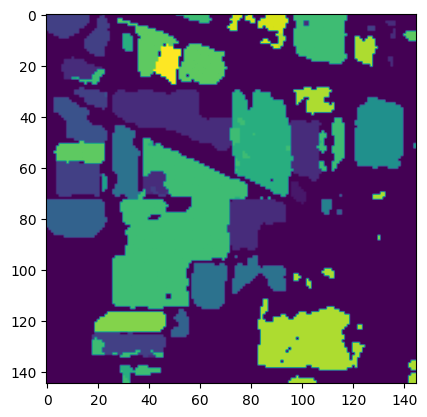

In [43]:
pipeline = load('lda_pipeline.joblib')    
data_lda = pipeline.predict(data_reshaped)

# Create a new array with shape (n, n, 17)
stacked_array = np.zeros((data_lda.shape[0], 16))

# Stack the image 17 times along the last axis
for i in range(16):
    stacked_array[:, i] = data_lda

data_lda = stacked_array

model = load_model('lda_model.h5')
cluster_labels_onehot = model.predict(data_lda)

preds = np.reshape(cluster_labels_onehot, (n, m, 17))

for sigma in tqdm(sigmas):
    smoothed_preds = cv2.GaussianBlur(preds, (0, 0), sigma)

    cluster_labels_reshaped = np.argmax(smoothed_preds, axis=2)
    accuracy = np.mean(cluster_labels_reshaped == labels)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sigma = sigma
        best_image = cluster_labels_reshaped

print(f"Best sigma={best_sigma:.1f} with accuracy={best_accuracy:.4f}")

cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)
print("MSE:", mse)
plt.imshow(best_image)
plt.show()
